# DeepHubble

Here, we are exploring the Pro-GAN as describes in [this paper](https://arxiv.org/pdf/1710.10196.pdf)

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as torchv
import torchx
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from PIL import Image

## Data

The ground truth data will be sampled from the Hubble eXtreme Deep Field (XDF). As seen below

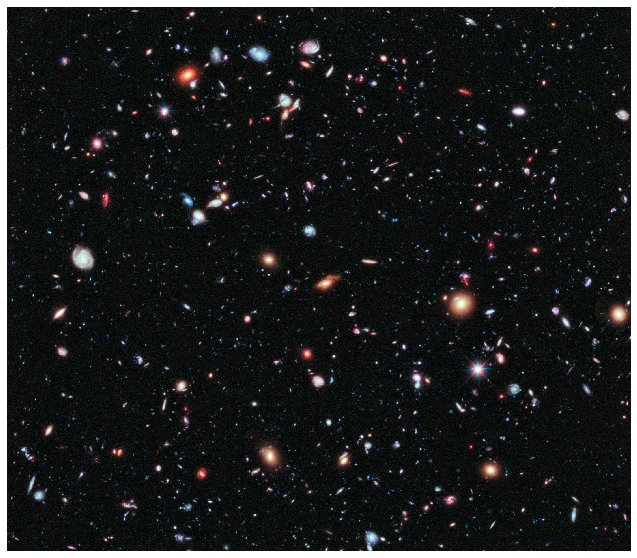

In [2]:
HubbleXDF = Image.open("../data/HubbleXDF_cropped.jpg")

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(HubbleXDF)
plt.axis('off')
plt.show()

We will be sampling images from the deep field image for our model to learn the distribution for. For the purpose of progressively growing our GAN, we sample $512 \times 512$ images from the XDF and then scale it down to $4\times4$ and then scaling back up as we train. For example:

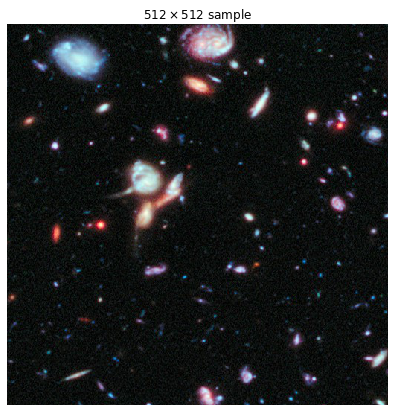

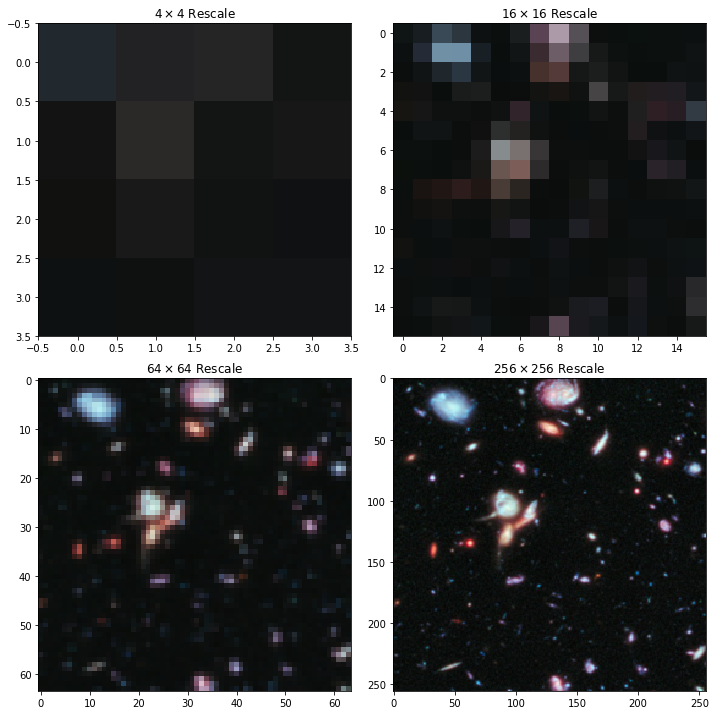

In [3]:
def sample_image(width, height):
    random.seed(20120925)  # Date the XDF was captured: September 25th, 2012
    return torchv.transforms.Compose([
        torchv.transforms.RandomCrop((512, 512)),
        torchv.transforms.Resize((width, height)),
    ])(HubbleXDF)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(sample_image(512, 512))
plt.axis("off")
plt.title(r"$512 \times 512$ sample")
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout()
ax[0][0].imshow(sample_image(4, 4))
ax[0][0].set_title(r"$4 \times 4$ Rescale")
ax[0][1].imshow(sample_image(16, 16))
ax[0][1].set_title(r"$16 \times 16$ Rescale")
ax[1][0].imshow(sample_image(64, 64))
ax[1][0].set_title(r"$64 \times 64$ Rescale")
ax[1][1].imshow(sample_image(256, 256))
ax[1][1].set_title(r"$256 \times 256$ Rescale")
plt.show()

In [4]:
class Dataset:
    def __init__(self, dim=64, size=9600):
        self.dim = dim
        self.size = size
        
        self.transforms = torchv.transforms.Compose([
            torchv.transforms.RandomCrop((512, 512)),
            torchv.transforms.Resize((self.dim, self.dim)),
            torchv.transforms.ToTensor()
        ])
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        return self.transforms(HubbleXDF)
    
def FromTensor(tensor):
    return np.moveaxis(fake_output.detach().cpu().numpy(), 1, -1)

## Training

In [5]:
def train(generator, discriminator, dataloader, epochs=10, suffix=""):
    criterion = torch.nn.BCELoss()
    
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0005, betas=(0.5, 0.999))
    
    iteration = 0
    
    with SummaryWriter("../data/runs", flush_secs=10, filename_suffix=suffix) as writer:
        for epoch in trange(epochs):
            with tqdm(total=len(dataloader), leave=False) as progress:
                generator.train()
                discriminator.train()
                progress.set_description(f"epoch {epoch+1}")

                generator_loss = 0
                discriminator_loss = 0

                for i, imgs in enumerate(dataloader):
                    imgs = imgs.cuda()

                    discriminator.zero_grad()

                    real_output = discriminator.forward(imgs)
                    discriminator_err_real = criterion(
                        real_output,                               
                        torch.ones(imgs.shape[0]).cuda()
                    )

                    noise = torch.randn(imgs.shape[0], 100).cuda()
                    fake_output = generator.forward(noise)
                    discriminator_err_fake = criterion(
                        discriminator.forward(fake_output.detach()), 
                        torch.zeros(imgs.shape[0]).cuda()
                    )

                    discriminator_err = discriminator_err_real + discriminator_err_fake
                    discriminator_err.backward()
                    discriminator_optimizer.step()

                    generator.zero_grad()

                    generator_err = criterion(
                        discriminator.forward(fake_output), 
                        torch.ones(imgs.shape[0]).cuda()
                    )
                    generator_err.backward()
                    generator_optimizer.step()

                    progress.set_postfix(dloss="%.6f" % discriminator_err.item(), gloss="%.6f" % generator_err.item())
                    progress.update()

                    generator_loss += generator_err.item()
                    discriminator_loss += discriminator_err.item()
                    if i % 10 == 9:
                        iteration += 1
                        writer.add_scalar("Generator/Loss", generator_loss / 10, iteration)
                        writer.add_scalar("Discriminator/Loss", discriminator_loss / 10, iteration)

                        generator_loss = 0
                        discriminator_loss = 0

                generator.save(f"../data/checkpoints/latest_generator{suffix}.pt")
                discriminator.save(f"../data/checkpoints/latest_discriminator{suffix}.pt")

## Model Architectures ($4 \times 4$)

The architectures for the generator and discriminator models for the initial $4 \times 4$ samples are as follows:

In [6]:
class Generator_4x4(torchx.nn.Module):
    def __init__(self, input_size=100, output_channels=3):
        super().__init__()
        
        self.input_size = input_size
        self.output_channels = output_channels
        
        self.layers = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(self.input_size, 64, 4, 1, 0),
            torchx.nn.ConvTranspose2dBatch(64, 64, 3, 1, 1),
        )
        self.conv_4x4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, self.output_channels, 3, 1, 1),
            torch.nn.Sigmoid()
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = x.view(-1, self.input_size, 1, 1)
        x = self.layers(x)
        return self.conv_4x4(x)
    

generator_4x4 = Generator_4x4()
generator_4x4.load("../data/checkpoints/final_generator_4x4.pt")

In [7]:
class Discriminator_4x4(torchx.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        self.input_channels = input_channels
        
        self.conv = torch.nn.Sequential(
            torchx.nn.Conv2dBatch(self.input_channels, 32, 4, 2),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(32, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1),
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return torch.flatten(x, 0)
    

# discriminator_4x4 = Discriminator_4x4()

In [8]:
# dataloader_4x4 = torch.utils.data.DataLoader(
#     Dataset(dim=4, size=9600),
#     batch_size=64,
#     num_workers=8,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
# )

In [9]:
# train(generator_4x4, discriminator_4x4, dataloader_4x4, epochs=10, suffix="_4x4")

## Generating 4x4 Images

After training, we can use the generator to generate images and see what the generator has learnt

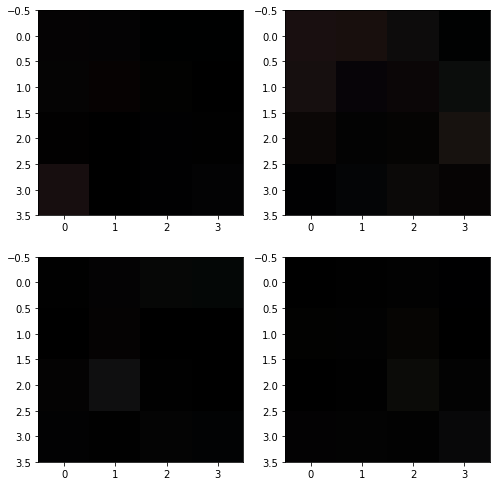

In [10]:
noise = torch.randn(4, 100)
fake_output = generator_4x4.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(7, 7))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
plt.show()

Evidently, it has learnt that space is mostly black with the occasional slightly brighter spot.

In [11]:
del generator_4x4
torch.cuda.empty_cache()

## Model Architectures ($8 \times 8$)

The architectures for the generator and discriminator models for the initial $8 \times 8$ samples are as follows.

Note: at this point, we have already trained the $4 \times 4$ GAN and so we will be building off the design of the previous design and loading in the weights from before.

In [12]:
class Generator_8x8(torchx.nn.Module):
    def __init__(self, input_size=100, output_channels=3):
        super().__init__()
        
        self.input_size = input_size
        self.output_channels = output_channels
        
        self.layers = torch.nn.Sequential(
            torchx.nn.ConvTranspose2dBatch(self.input_size, 64, 4, 1, 0),
            torchx.nn.ConvTranspose2dBatch(64, 64, 3, 1, 1),
            torchx.nn.ConvTranspose2dBatch(64, 64, 4, 2, 1),
#             torchx.nn.ConvTranspose2dBatch(64, 64, 3, 1, 1),
        )
        self.conv_4x4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(64, self.output_channels, 3, 1, 1),
            torch.nn.Sigmoid()
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = x.view(-1, self.input_size, 1, 1)
        x = self.layers(x)
        return self.conv_4x4(x)
    

generator_8x8 = Generator_8x8().cuda()
generator_8x8.load("../data/checkpoints/final_generator_8x8.pt")

In [13]:
class Discriminator_8x8(torchx.nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        
        self.input_channels = input_channels
        
        self.conv = torch.nn.Sequential(
            torchx.nn.Conv2dBatch(self.input_channels, 32, 4, 2),
            torchx.nn.Conv2dBatch(32, 64, 3, 1, 1),
            torchx.nn.Conv2dBatch(64, 32, 3, 1),
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(32, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1),
        )
        
        self.reset_parameters()
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return torch.flatten(x, 0)
    

# discriminator_8x8 = Discriminator_8x8().cuda()
# discriminator_8x8.load("../data/checkpoints/final_discriminator_4x4.pt")

## Pre-Training Generator

Before training, the output of our generator looks something like this:

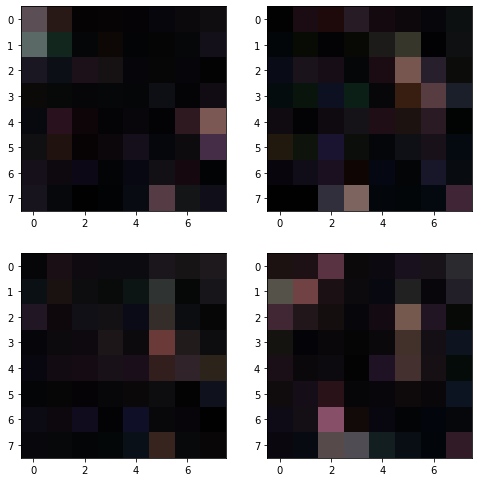

In [14]:
noise = torch.randn(4, 100).cuda()
fake_output = generator_8x8.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(7, 7))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
plt.show()

In [15]:
# dataloader_8x8 = torch.utils.data.DataLoader(
#     Dataset(dim=8, size=9600),
#     batch_size=64,
#     num_workers=8,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
# )

In [16]:
# train(generator_8x8, discriminator_8x8, dataloader_8x8, epochs=10, suffix="_8x8")

## Generating 8x8 Images

After training, we can use the generator to generate images and see what the generator has learnt

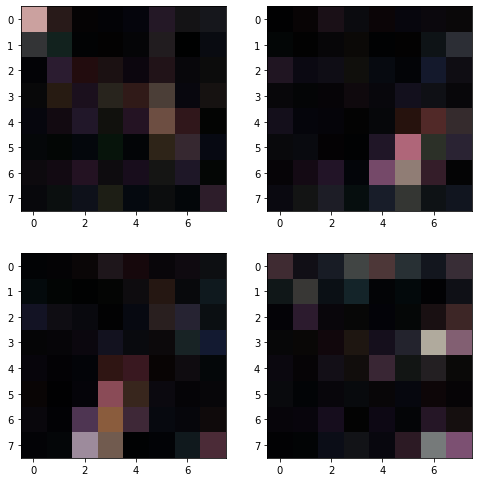

In [17]:
noise = torch.randn(4, 100).cuda()
fake_output = generator_8x8.forward(noise)
fake_output = FromTensor(fake_output)

fig, ax = plt.subplots(2, 2, figsize=(7, 7))
fig.tight_layout()
ax[0][0].imshow(fake_output[0])
ax[0][1].imshow(fake_output[1])
ax[1][0].imshow(fake_output[2])
ax[1][1].imshow(fake_output[3])
plt.show()

Evidently, it has learnt that space is mostly black with the occasional slightly brighter spot.

In [18]:
del generator_8x8
torch.cuda.empty_cache()